In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
###################################
# TensorFlow wizardry
import tensorflow as tf
config = tf.ConfigProto()
 
# Don’t pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.05
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
 
# Create a session with the above options specified.
from keras import optimizers, regularizers
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense, Dropout, Input
from keras import backend as k

k.tensorflow_backend.set_session(tf.Session(config=config))
#k.tensorflow_backend.set_session(tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
###################################

Using TensorFlow backend.


In [3]:
#----------------------------------Import modules------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn import preprocessing
sns.set_style("whitegrid")
np.random.seed(23)
import time
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict


In [4]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [5]:
pathds = '/home/user/01Code/00Datasets_final/'

In [6]:
#df_chunk = pd.read_csv(pathds+'SubsetAllSamples/ThirdCloneID10bal_minmax.csv', chunksize=1000)
#df = df_chunk.get_chunk(300000)
df = pd.read_csv(pathds+'SubsetAllSamples/ThirdCloneID10bal_minmax.csv')

In [7]:
df.shape

(455154, 49)

#### 4.2 Explaining the data

In [8]:
#if you don't have an intuitive sense of how imbalanced these two classes are, let's go visual
count_classes = pd.value_counts(df['class'], sort = True)
print('Class 0:', count_classes[0])
print('Class 1:', count_classes[1])
print('Proportion:', round(count_classes[0] / count_classes[1], 3), ': 1')

Class 0: 227577
Class 1: 227577
Proportion: 1.0 : 1


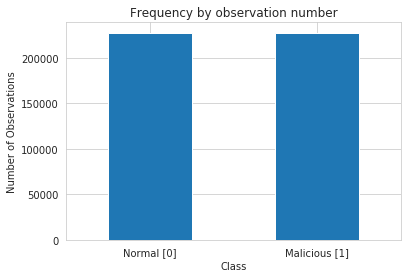

In [9]:
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Normal [0]','Malicious [1]'])
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [10]:
#set random seed and percentage of test data
RANDOM_SEED = 23 #used to help randomly select the data points
TEST_PCT = 0.20 # 20% of the data

In [11]:
train, test_df = train_test_split(df, test_size=TEST_PCT, random_state=RANDOM_SEED)

+ df -> original dataset 
+ train -> subset of 80% from original dataset 
+ test_df -> subset of 20% from original dataset 

In [12]:
train_df, dev_df = train_test_split(train, test_size=TEST_PCT, random_state=RANDOM_SEED)

+ train -> subset of 80% from original dataset 
+ train_df -> subset of 80% from train
+ dev_df -> subset of 20% from train

In [13]:
# Check distribution of mal samples in train and test set
print(train_df.iloc[:, 48].sum()/train_df.shape[0]) 
print(dev_df.iloc[:, 48].sum()/dev_df.shape[0]) 
print(test_df.iloc[:, 48].sum()/test_df.shape[0])

0.5006728504830106
0.5012838997596979
0.4968197646955433


In [14]:
train_x = train_df.iloc[:, :48] 
dev_x = dev_df.iloc[:, :48] 
test_x = test_df.iloc[:, :48] 

+ train_x -> features of train_df **Training subset for AE**
+ dev_x -> features of dev_df **Validation subset for AE**
+ test_x -> features of test_df **Testing subset for ANN**

In [15]:
# Define the final train and test sets
train_y = train_df.iloc[:, 48]
dev_y = dev_df.iloc[:, 48]
test_y = test_df.iloc[:, 48]

+ train_y -> **Labels for supervised training of ANN**
+ dev_y -> labels of dev_df  *not used for AE neither ANN*
+ test_y -> labels of test_df  **Ground Truth for predictions of supervised ANN**

In [16]:
train_x =np.array(train_x)
dev_x =np.array(dev_x)
test_x = np.array(test_x)

train_y = np.array(train_y)
dev_y = np.array(dev_y)
test_y = np.array(test_y)

print(train_x.shape[1])

48


### Autoencoder Function

encoding_dim - 2

Epoch 94/300 78596/78596 [==============================] - 10s 125us/step 
- loss: 3.8990e-05 - acc: 0.0237 - 
        val_loss: 3.9704e-05 - val_acc: 0.0236

In [17]:
def ae(factor_enc_dim, enc_activation, dec_activation, 
                optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer #RELU
    encoded = Dense(encoding_dim, activation=enc_activation, name='encoded_bottle_neck')(input_data)
    ### Define decoding layer #SIMOID
    decoded = Dense(train_x.shape[1], activation=dec_activation)(encoded)
    ### Create the autoencoder model
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])
    
    print(autoencoder.summary())
    
    encoder = Model(input_data, encoded)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return autoencoder,encoded_train_x,encoded_test_x

In [18]:
def sae(factor_enc_dim, output_activation,
        optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer
    encoded = Dense(encoding_dim, activation='relu', name='input_layer')(input_data)
    encoded = Dense(int(encoding_dim/2), activation='relu')(encoded) ##Stacked AE
    encoded_bottle_neck = Dense(int(encoding_dim/4), activation='relu', name='enc_bottle_neck')(encoded) ##Stacked AE
    
    ### Define decoding layer
    decoded = Dense(int(encoding_dim/2), activation='relu')(encoded_bottle_neck) ##Stacked AE
    decoded = Dense(encoding_dim, activation='relu')(decoded) ##Stacked AE
    decoded = Dense(train_x.shape[1], activation=output_activation)(decoded)
    
    ### Create the autoencoder model
    sae = Model(input_data, decoded)
    sae.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
    
    print(sae.summary())

    encoder = Model(input_data, encoded_bottle_neck)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return sae,encoded_train_x,encoded_test_x

In [19]:
def spae(factor_enc_dim, output_activation, 
                optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer
    encoded = Dense(encoding_dim, activity_regularizer=regularizers.l1(1e-4), activation='relu', name='encoded_bottle_neck')(input_data)
    ### Define decoding layer
    decoded = Dense(train_x.shape[1], activation=output_activation)(encoded)
    ### Create the autoencoder model
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])
    
    print(autoencoder.summary())
    
    encoder = Model(input_data, encoded)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return autoencoder,encoded_train_x,encoded_test_x

In [20]:
def fit_ae(checkpoint_file, autoencoder,
           epochs, batch_size, shuffle):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    cp = ModelCheckpoint(filepath=checkpoint_file,
                                   save_best_only=True,
                                   verbose=0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    start_time = time.time()
    print(time.ctime(start_time))

    hist_auto = autoencoder.fit(train_x, train_x,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=shuffle,
                    verbose=1,
                    callbacks=[early_stopping, cp, tb],
                    validation_data=(dev_x, dev_x))

    elapsed_time = (time.time() - start_time)
    print("--- AE spent %s seconds ---" % elapsed_time)
    
    return hist_auto

In [21]:
def plot_hist_auto(hist_auto, fig_file):
    best_loss_value = hist_auto.history['loss'][-1]
    print('Best loss value:', best_loss_value)

    # Summarize history for loss
    plt.figure()
    plt.plot(hist_auto.history['loss'])
    plt.plot(hist_auto.history['val_loss'])
    plt.title('Autoencoder model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.savefig(fig_file)
    plt.show()
    
    return best_loss_value

In [22]:
def ann_2h(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(36, activation="relu", kernel_initializer=init_mode)) #rezvy

    model.add(Dense(24, activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [23]:
def ann_2h_(neurons,encoded_train_x,init_mode,activation_input,
               dropout_rate,activation_output,
               loss,lr):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
#                     kernel_constraint=maxnorm(weight_constraint)
#                     kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(36, activation="relu")) #rezvy

    model.add(Dense(24, activation="relu")) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example

    optimizer = optimizers.Adam(lr=lr)
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [24]:
def ann_2h__(neurons,encoded_train_x,activation_input,
             activation_output,loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
#                     kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
#                     kernel_constraint=maxnorm(weight_constraint)
#                     kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(36, activation="relu")) #rezvy

    model.add(Dense(24, activation="relu")) #rezvy
#     model.add(BatchNormalization()) #commented for ex
#     model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example

#     optimizer = optimizers.Adam(lr=lr)
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [25]:
def ann_1h_36n(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(36, activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [26]:
def ann_1h_24n(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(24, activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [27]:
def ann_1h_24n_(neurons,encoded_train_x,activation_input,
               activation_output,loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
#                     kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
#                     kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(24, activation="relu")) #rezvy
    
#     model.add(BatchNormalization()) #commented for ex
#     model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [28]:
def ann_fit(checkpoint_file,ann,enc_train_x,train_y,epochs,shuffle,batch_size):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    cp = ModelCheckpoint(filepath=checkpoint_file,
                                   save_best_only=True,
                                   verbose=0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    start_time = time.time()
    print(time.ctime(start_time))

    history = ann.fit(enc_train_x,
                      train_y,
                      validation_split=0.2,
                      callbacks=[early_stopping],
                      epochs=epochs,
                      shuffle=shuffle,
                      batch_size=batch_size,
                      verbose=1)

    elapsed_time = (time.time() - start_time)
    print("--- ANN spent %s seconds ---" % elapsed_time)

    return history

In [29]:
def ann_predict(ann,enc_test_x):
    pred_ann_prob = ann.predict(enc_test_x)
    pred_ann_prob.shape
    pred_ann_prob = pred_ann_prob[:,0]
    pred_ann_01 = np.where(pred_ann_prob > 0.5, 1, 0)
    
    #Print accuracy
    acc_ann = accuracy_score(test_y, pred_ann_01)
    print('Overall accuracy of Neural Network model:', acc_ann)

    classiBM = "NN"
    preBM = (sm.precision_score(test_y, pred_ann_01)*100) 
    recallBM = (sm.recall_score(test_y, pred_ann_01)*100) 
    f1scoreBM = (sm.f1_score(test_y, pred_ann_01)*100)
    print(sm.classification_report(test_y, pred_ann_01))
    
    return pred_ann_prob, pred_ann_01

In [30]:
def plot_roc_cm(pred_ann_prob, pred_ann_01, roc_file, cm_file):
    false_positive_rate, recall, thresholds = roc_curve(test_y, pred_ann_prob)
    roc_auc = auc(false_positive_rate, recall)
    plt.figure()
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1-Specificity)')
    plt.savefig(roc_file)
    plt.show()
    
    cm = confusion_matrix(test_y, pred_ann_01)
    labels = ['Normal', 'Malicious']
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="RdYlGn", vmin = 0.2);
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.savefig(cm_file)
    plt.show()
    

loss: 2.7516e-05 - acc: 0.0407 

val_loss: 2.7072e-05 - val_acc: 0.0399

In [31]:
ae_sigmoid_adam_logcosh,enc_train_x_asal,enc_test_x_asal = ae(factor_enc_dim = 1.5,
                                                              enc_activation = 'relu',
                                                              dec_activation = 'sigmoid',
                                                              optimizer='Adam',
                                                              loss='logcosh')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48)                0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 32)                1568      
_________________________________________________________________
dense_1 (Dense)              (None, 48)                1584      
Total params: 3,152
Trainable params: 3,152
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
#ae_sigmoid_adam_logcosh = load_model('ae_sigmoid_adam_logcosh_redds10bal.h5')

In [33]:
hist_ae_sigmoid_adam_logcosh = fit_ae(checkpoint_file = "ae_sigmoid_adam_logcosh_redds10bal.h5",
                                        autoencoder = ae_sigmoid_adam_logcosh, 
                                        epochs = 200, 
                                        batch_size = 48, 
                                        shuffle = False)

Sat Jun  8 20:37:32 2019
Instructions for updating:
Use tf.cast instead.
Train on 291298 samples, validate on 72825 samples
Epoch 1/200
291298/291298 [==============================] - 12s 41us/step - loss: 0.0030 - acc: 0.0593 - val_loss: 6.0932e-05 - val_acc: 0.0612
Epoch 2/200
291298/291298 [==============================] - 12s 40us/step - loss: 5.5876e-05 - acc: 0.0606 - val_loss: 5.3459e-05 - val_acc: 0.0612
Epoch 3/200
291298/291298 [==============================] - 12s 40us/step - loss: 4.9057e-05 - acc: 0.0575 - val_loss: 4.7605e-05 - val_acc: 0.0526
Epoch 4/200
291298/291298 [==============================] - 12s 40us/step - loss: 4.7729e-05 - acc: 0.0462 - val_loss: 4.7337e-05 - val_acc: 0.0407
Epoch 5/200
291298/291298 [==============================] - 12s 40us/step - loss: 4.7555e-05 - acc: 0.0351 - val_loss: 4.7190e-05 - val_acc: 0.0300
Epoch 6/200
291298/291298 [==============================] - 11s 39us/step - loss: 4.7433e-05 - acc: 0.0259 - val_loss: 4.7092e-05 - va

Best loss value: 1.3964976966679882e-05


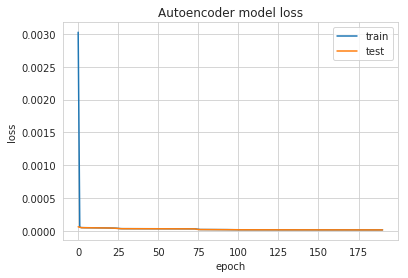

In [34]:
best_loss_value_ae_sigmoid_adam_logcosh = plot_hist_auto(hist_ae_sigmoid_adam_logcosh, './Figures/ae_sigmoid_adam_logcosh.png')

In [35]:
ae_siglin_adam_logcosh,enc_train_x_aslal,enc_test_x_aslal = ae(factor_enc_dim = 1.5,
                                                              enc_activation = 'sigmoid',
                                                              dec_activation = 'linear',
                                                              optimizer='Adam',
                                                              loss='logcosh')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48)                0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 32)                1568      
_________________________________________________________________
dense_2 (Dense)              (None, 48)                1584      
Total params: 3,152
Trainable params: 3,152
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
#ae_siglin_adam_logcosh = load_model('ae_siglin_adam_logcosh_redds10bal.h5')

In [37]:
hist_ae_siglin_adam_logcosh = fit_ae(checkpoint_file = "ae_siglin_adam_logcosh_redds10bal.h5",
                                        autoencoder = ae_siglin_adam_logcosh, 
                                        epochs = 200, 
                                        batch_size = 48, 
                                        shuffle = False)

Sat Jun  8 21:11:43 2019
Train on 291298 samples, validate on 72825 samples
Epoch 1/200
291298/291298 [==============================] - 11s 36us/step - loss: 0.0041 - acc: 0.0764 - val_loss: 8.5460e-05 - val_acc: 0.0570
Epoch 2/200
291298/291298 [==============================] - 11s 36us/step - loss: 4.8990e-05 - acc: 0.0368 - val_loss: 2.8091e-05 - val_acc: 0.0655
Epoch 3/200
291298/291298 [==============================] - 10s 36us/step - loss: 2.1206e-05 - acc: 0.0350 - val_loss: 1.6582e-05 - val_acc: 0.0440
Epoch 4/200
291298/291298 [==============================] - 10s 36us/step - loss: 1.3374e-05 - acc: 0.0362 - val_loss: 1.1180e-05 - val_acc: 0.0498
Epoch 5/200
291298/291298 [==============================] - 11s 36us/step - loss: 9.7674e-06 - acc: 0.0361 - val_loss: 7.9536e-06 - val_acc: 0.0345
Epoch 6/200
291298/291298 [==============================] - 10s 36us/step - loss: 7.7298e-06 - acc: 0.0361 - val_loss: 6.8249e-06 - val_acc: 0.0224
Epoch 7/200
291298/291298 [=======

Best loss value: 1.8328960478194525e-06


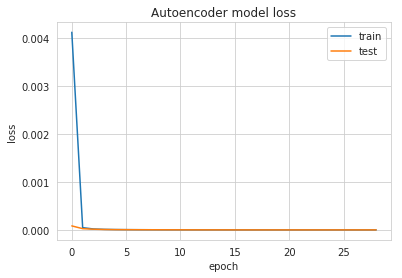

In [38]:
best_loss_value_ae_siglin_adam_logcosh = plot_hist_auto(hist_ae_siglin_adam_logcosh, './Figures/hist_ae_siglin_adam_logcosh.png')

In [39]:
ae_sigmoid_adam_mse,enc_train_x_asam,enc_test_x_asam = ae(factor_enc_dim = 1.5,
                                                          enc_activation = 'relu',
                                                          dec_activation = 'sigmoid',
                                                          optimizer='Adam',
                                                          loss='mean_squared_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 48)                0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 32)                1568      
_________________________________________________________________
dense_3 (Dense)              (None, 48)                1584      
Total params: 3,152
Trainable params: 3,152
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
#ae_sigmoid_adam_mse = load_model('ae_sigmoid_adam_mse_redds10bal.h5')

In [41]:
hist_ae_sigmoid_adam_mse = fit_ae(checkpoint_file = "ae_sigmoid_adam_mse_redds10bal.h5",
                                  autoencoder = ae_sigmoid_adam_mse, 
                                  epochs = 200, 
                                  batch_size = 48,
                                  shuffle = False)

Sat Jun  8 21:16:52 2019
Train on 291298 samples, validate on 72825 samples
Epoch 1/200
291298/291298 [==============================] - 10s 36us/step - loss: 0.0067 - acc: 0.0091 - val_loss: 1.2815e-04 - val_acc: 0.0000e+00
Epoch 2/200
291298/291298 [==============================] - 10s 35us/step - loss: 1.0853e-04 - acc: 0.0000e+00 - val_loss: 9.7881e-05 - val_acc: 0.0000e+00
Epoch 3/200
291298/291298 [==============================] - 10s 35us/step - loss: 9.6712e-05 - acc: 0.0000e+00 - val_loss: 9.5692e-05 - val_acc: 0.0000e+00
Epoch 4/200
291298/291298 [==============================] - 10s 36us/step - loss: 9.5901e-05 - acc: 0.0000e+00 - val_loss: 9.5327e-05 - val_acc: 0.0000e+00
Epoch 5/200
291298/291298 [==============================] - 10s 35us/step - loss: 9.5622e-05 - acc: 0.0000e+00 - val_loss: 9.5150e-05 - val_acc: 0.0000e+00
Epoch 6/200
291298/291298 [==============================] - 10s 35us/step - loss: 9.5397e-05 - acc: 0.0000e+00 - val_loss: 9.4734e-05 - val_acc: 0

Best loss value: 3.3886729094675456e-05


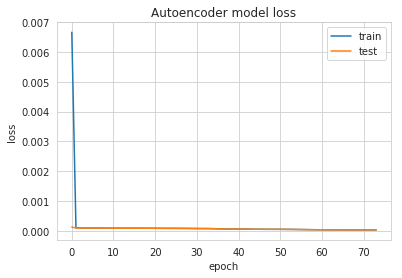

In [42]:
best_loss_value_ae_sigmoid_adam_mse  = plot_hist_auto(hist_ae_sigmoid_adam_mse, './Figures/hist_ae_sigmoid_adam_mse.png')

In [43]:
ae_sigsig_adam_logcosh,enc_train_x_assal,enc_test_x_assal = ae(factor_enc_dim = 1.5,
                                                          enc_activation = 'sigmoid',
                                                          dec_activation = 'sigmoid',
                                                          optimizer='Adam',
                                                          loss='logcosh')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 48)                0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 32)                1568      
_________________________________________________________________
dense_4 (Dense)              (None, 48)                1584      
Total params: 3,152
Trainable params: 3,152
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
#ae_sigsig_adam_logcosh = load_model('ae_sigsig_adam_logcosh_redds10bal.h5')

In [45]:
hist_ae_sigsig_adam_logcosh = fit_ae(checkpoint_file = "ae_sigsig_adam_logcosh_redds10bal.h5",
                                  autoencoder = ae_sigsig_adam_logcosh, 
                                  epochs = 200, 
                                  batch_size = 48,
                                  shuffle = False)

Sat Jun  8 21:29:45 2019
Train on 291298 samples, validate on 72825 samples
Epoch 1/200
291298/291298 [==============================] - 11s 37us/step - loss: 0.0095 - acc: 0.0480 - val_loss: 0.0010 - val_acc: 0.0252
Epoch 2/200
291298/291298 [==============================] - 11s 37us/step - loss: 3.9238e-04 - acc: 0.0056 - val_loss: 1.5048e-04 - val_acc: 0.0000e+00
Epoch 3/200
291298/291298 [==============================] - 11s 38us/step - loss: 1.0775e-04 - acc: 0.0000e+00 - val_loss: 8.2494e-05 - val_acc: 0.0000e+00
Epoch 4/200
291298/291298 [==============================] - 12s 41us/step - loss: 7.1205e-05 - acc: 4.4628e-05 - val_loss: 6.2333e-05 - val_acc: 1.5105e-04
Epoch 5/200
291298/291298 [==============================] - 12s 41us/step - loss: 5.6640e-05 - acc: 8.7883e-04 - val_loss: 5.2184e-05 - val_acc: 0.0016
Epoch 6/200
291298/291298 [==============================] - 12s 41us/step - loss: 4.9832e-05 - acc: 0.0060 - val_loss: 4.7392e-05 - val_acc: 0.0065
Epoch 7/200
29

Best loss value: 2.6876489954489138e-06


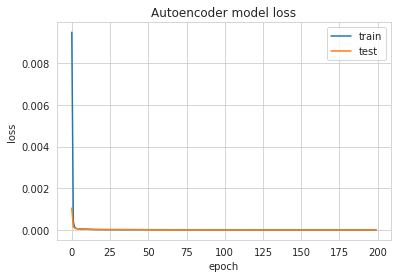

In [46]:
best_loss_value_ae_sigsig_adam_logcosh  = plot_hist_auto(hist_ae_sigsig_adam_logcosh, './Figures/hist_ae_sigsig_adam_logcosh.png')

In [47]:
loss_valueDict = {
    'loss_value_ae_sigmoid_adam_logcosh': best_loss_value_ae_sigmoid_adam_logcosh,
    'loss_value_ae_sigmoid_adam_mse': best_loss_value_ae_sigmoid_adam_mse,
    'loss_value_ae_siglin_adam_logcosh': best_loss_value_ae_siglin_adam_logcosh,
    'loss_value_ae_sigsig_adam_logcosh': best_loss_value_ae_sigsig_adam_logcosh
    }

In [48]:
loss_valueDict

{'loss_value_ae_sigmoid_adam_logcosh': 1.3964976966679882e-05,
 'loss_value_ae_sigmoid_adam_mse': 3.3886729094675456e-05,
 'loss_value_ae_siglin_adam_logcosh': 1.8328960478194525e-06,
 'loss_value_ae_sigsig_adam_logcosh': 2.6876489954489138e-06}

In [49]:
print(enc_train_x_asal.shape)
print(enc_test_x_asal.shape)

print(enc_train_x_asam.shape)
print(enc_test_x_asam.shape)

print(enc_train_x_aslal.shape)
print(enc_test_x_aslal.shape)

print(enc_train_x_assal.shape)
print(enc_test_x_assal.shape)

(291298, 32)
(91031, 32)
(291298, 32)
(91031, 32)
(291298, 32)
(91031, 32)
(291298, 32)
(91031, 32)


#### ====================== Fail ANN ======================

In [50]:
ann36n_unisoftsigbinlosadam = ann_1h_36n(neurons=48,
                                      encoded_train_x=enc_train_x_asal,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 48)                1584      
_________________________________________________________________
dense_6 (Dense)              (None, 36)                1764      
_________________________________________________________________
batch_normalization_1 (Batch (None, 36)                144       
_________________________________________________________________
dropout_1 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 37        
Total params: 3,529
Trainable params: 3,457
Non-trainable params: 72
_________________________________________________________________
None


In [51]:
hist_ann36n_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann36n_unisoftsigbinlosadam_redds10bal.h5",
                                        ann = ann36n_unisoftsigbinlosadam,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 48)

Sat Jun  8 22:06:04 2019
Train on 233038 samples, validate on 58260 samples
Epoch 1/200
233038/233038 [==============================] - 16s 68us/step - loss: 0.5575 - acc: 0.6898 - val_loss: 0.4984 - val_acc: 0.7381
Epoch 2/200
233038/233038 [==============================] - 15s 65us/step - loss: 0.4882 - acc: 0.7487 - val_loss: 0.4793 - val_acc: 0.7567
Epoch 3/200
233038/233038 [==============================] - 15s 66us/step - loss: 0.4630 - acc: 0.7644 - val_loss: 0.4405 - val_acc: 0.7838
Epoch 4/200
233038/233038 [==============================] - 15s 66us/step - loss: 0.4476 - acc: 0.7727 - val_loss: 0.4241 - val_acc: 0.7895
Epoch 5/200
233038/233038 [==============================] - 15s 66us/step - loss: 0.4375 - acc: 0.7790 - val_loss: 0.4275 - val_acc: 0.7884
Epoch 6/200
233038/233038 [==============================] - 15s 66us/step - loss: 0.4287 - acc: 0.7834 - val_loss: 0.4327 - val_acc: 0.7863
Epoch 7/200
233038/233038 [==============================] - 15s 66us/step - l

Best loss value: 0.30089075283231614


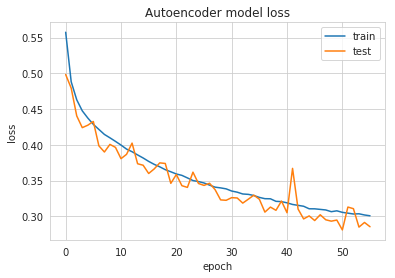

In [52]:
best_loss_value_ann36n_unisoftsigbinlosadam = plot_hist_auto(hist_ann36n_unisoftsigbinlosadam, './Figures/ann36_unisoftsigbinlosadam.png')

In [53]:
pred_ann36n_prob_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam = ann_predict(ann36n_unisoftsigbinlosadam,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.8697916094517253
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     45805
           1       0.84      0.90      0.87     45226

   micro avg       0.87      0.87      0.87     91031
   macro avg       0.87      0.87      0.87     91031
weighted avg       0.87      0.87      0.87     91031



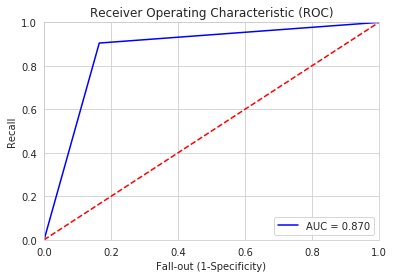

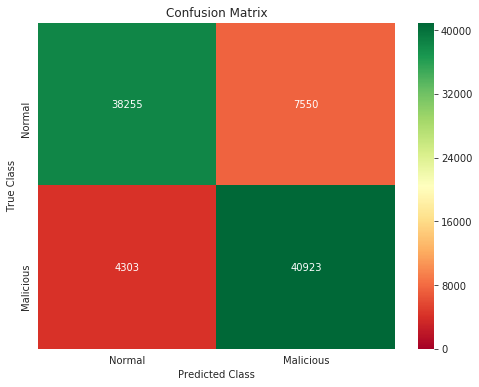

In [54]:
plot_roc_cm(pred_ann36n_01_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam, './Figures/ROC_ann36n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann36n_unisoftsigbinlosadam_redds10bal.png')

In [55]:
ann36n_unisoftsigbinlosadam2 = ann_1h_36n(neurons=48,
                                      encoded_train_x=enc_train_x_asam,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 48)                1584      
_________________________________________________________________
dense_9 (Dense)              (None, 36)                1764      
_________________________________________________________________
batch_normalization_2 (Batch (None, 36)                144       
_________________________________________________________________
dropout_2 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 37        
Total params: 3,529
Trainable params: 3,457
Non-trainable params: 72
_________________________________________________________________
None


In [56]:
hist_ann36n_unisoftsigbinlosadam2 = ann_fit(checkpoint_file = "ann36n_unisoftsigbinlosadam2_redds10bal.h5",
                                        ann = ann36n_unisoftsigbinlosadam2,
                                        enc_train_x = enc_train_x_asam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 48)

Sat Jun  8 22:20:25 2019
Train on 233038 samples, validate on 58260 samples
Epoch 1/200
233038/233038 [==============================] - 16s 69us/step - loss: 0.5578 - acc: 0.6905 - val_loss: 0.5058 - val_acc: 0.7356
Epoch 2/200
233038/233038 [==============================] - 15s 66us/step - loss: 0.4976 - acc: 0.7401 - val_loss: 0.4840 - val_acc: 0.7484
Epoch 3/200
233038/233038 [==============================] - 15s 66us/step - loss: 0.4734 - acc: 0.7575 - val_loss: 0.4627 - val_acc: 0.7634
Epoch 4/200
233038/233038 [==============================] - 15s 66us/step - loss: 0.4596 - acc: 0.7661 - val_loss: 0.4464 - val_acc: 0.7775
Epoch 5/200
233038/233038 [==============================] - 15s 66us/step - loss: 0.4481 - acc: 0.7736 - val_loss: 0.4243 - val_acc: 0.7839
Epoch 6/200
233038/233038 [==============================] - 15s 66us/step - loss: 0.4376 - acc: 0.7797 - val_loss: 0.4191 - val_acc: 0.7844
Epoch 7/200
233038/233038 [==============================] - 15s 66us/step - l

Best loss value: 0.32188910398540244


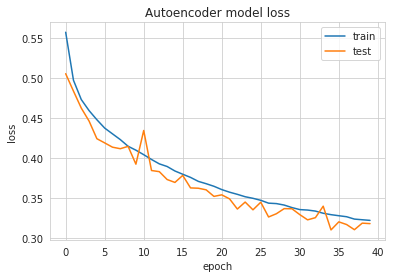

In [57]:
best_loss_value_ann36n_unisoftsigbinlosadam2 = plot_hist_auto(hist_ann36n_unisoftsigbinlosadam2, './Figures/ann36_unisoftsigbinlosadam2.png')

In [58]:
pred_ann36n_prob_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam2 = ann_predict(ann36n_unisoftsigbinlosadam2,enc_test_x_asam)

Overall accuracy of Neural Network model: 0.8506662565499665
              precision    recall  f1-score   support

           0       0.87      0.82      0.85     45805
           1       0.83      0.88      0.85     45226

   micro avg       0.85      0.85      0.85     91031
   macro avg       0.85      0.85      0.85     91031
weighted avg       0.85      0.85      0.85     91031



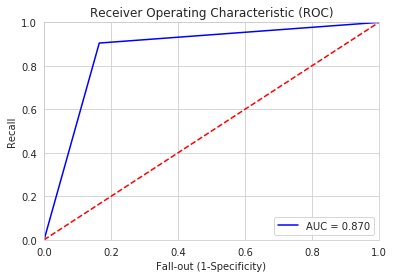

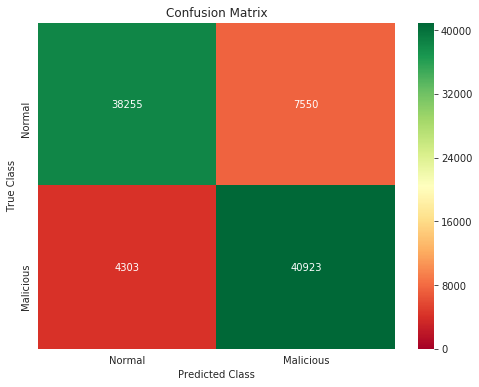

In [59]:
plot_roc_cm(pred_ann36n_01_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam, './Figures/ROC_ann36n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann36n_unisoftsigbinlosadam_redds10bal.png')

In [60]:
ann24n_unisoftsigbinlosadam = ann_1h_24n(neurons=48,
                                      encoded_train_x=enc_train_x_asam,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_12 (Dense)             (None, 24)                1176      
_________________________________________________________________
batch_normalization_3 (Batch (None, 24)                96        
_________________________________________________________________
dropout_3 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 25        
Total params: 2,881
Trainable params: 2,833
Non-trainable params: 48
_________________________________________________________________
None


In [61]:
hist_ann24n_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann24n_unisoftsigbinlosadam_redds10bal.h5",
                                        ann = ann24n_unisoftsigbinlosadam,
                                        enc_train_x = enc_train_x_asam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 48)

Sat Jun  8 22:30:36 2019
Train on 233038 samples, validate on 58260 samples
Epoch 1/200
233038/233038 [==============================] - 15s 66us/step - loss: 0.5458 - acc: 0.6987 - val_loss: 0.4952 - val_acc: 0.7481
Epoch 2/200
233038/233038 [==============================] - 15s 66us/step - loss: 0.4867 - acc: 0.7469 - val_loss: 0.4667 - val_acc: 0.7653
Epoch 3/200
233038/233038 [==============================] - 15s 65us/step - loss: 0.4681 - acc: 0.7610 - val_loss: 0.4690 - val_acc: 0.7639
Epoch 4/200
233038/233038 [==============================] - 15s 65us/step - loss: 0.4568 - acc: 0.7695 - val_loss: 0.4595 - val_acc: 0.7738
Epoch 5/200
233038/233038 [==============================] - 15s 64us/step - loss: 0.4481 - acc: 0.7763 - val_loss: 0.4305 - val_acc: 0.7842
Epoch 6/200
233038/233038 [==============================] - 15s 65us/step - loss: 0.4395 - acc: 0.7817 - val_loss: 0.4240 - val_acc: 0.7914
Epoch 7/200
233038/233038 [==============================] - 15s 64us/step - l

Best loss value: 0.345635194738501


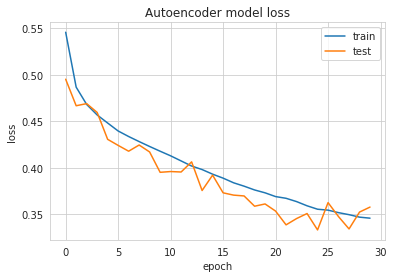

In [62]:
best_loss_value_ann24n_unisoftsigbinlosadam = plot_hist_auto(hist_ann24n_unisoftsigbinlosadam, './Figures/ann24_unisoftsigbinlosadam.png')

In [63]:
pred_ann24n_prob_unisoftsigbinlosadam, pred_ann24n_01_unisoftsigbinlosadam = ann_predict(ann24n_unisoftsigbinlosadam,enc_test_x_asam)

Overall accuracy of Neural Network model: 0.8285419252782019
              precision    recall  f1-score   support

           0       0.81      0.86      0.84     45805
           1       0.85      0.79      0.82     45226

   micro avg       0.83      0.83      0.83     91031
   macro avg       0.83      0.83      0.83     91031
weighted avg       0.83      0.83      0.83     91031



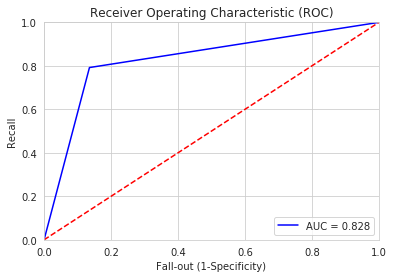

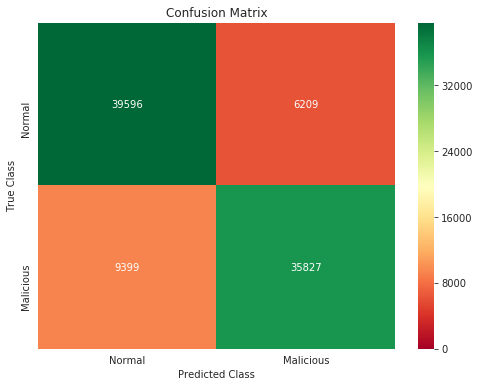

In [64]:
plot_roc_cm(pred_ann24n_01_unisoftsigbinlosadam, pred_ann24n_01_unisoftsigbinlosadam, './Figures/ROC_ann24n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann24n_unisoftsigbinlosadam_redds10bal.png')

In [65]:
ann_2h_unisoftsigbinlosadam = ann_2h(neurons=48,
                                      encoded_train_x=enc_train_x_asam,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_15 (Dense)             (None, 36)                1764      
_________________________________________________________________
dense_16 (Dense)             (None, 24)                888       
_________________________________________________________________
batch_normalization_4 (Batch (None, 24)                96        
_________________________________________________________________
dropout_4 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 25        
Total params: 4,357
Trainable params: 4,309
Non-trainable params: 48
_________________________________________________________________
None


In [66]:
hist_ann_2h_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam_redds10bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam,
                                        enc_train_x = enc_train_x_asam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 48)

Sat Jun  8 22:38:09 2019
Train on 233038 samples, validate on 58260 samples
Epoch 1/200
233038/233038 [==============================] - 17s 74us/step - loss: 0.5547 - acc: 0.6948 - val_loss: 0.4897 - val_acc: 0.7568
Epoch 2/200
233038/233038 [==============================] - 16s 71us/step - loss: 0.4661 - acc: 0.7620 - val_loss: 0.4595 - val_acc: 0.7590
Epoch 3/200
233038/233038 [==============================] - 16s 71us/step - loss: 0.4265 - acc: 0.7868 - val_loss: 0.4088 - val_acc: 0.7975
Epoch 4/200
233038/233038 [==============================] - 17s 71us/step - loss: 0.4002 - acc: 0.8018 - val_loss: 0.3811 - val_acc: 0.8076
Epoch 5/200
233038/233038 [==============================] - 17s 71us/step - loss: 0.3846 - acc: 0.8103 - val_loss: 0.3851 - val_acc: 0.8101
Epoch 6/200
233038/233038 [==============================] - 16s 71us/step - loss: 0.3711 - acc: 0.8173 - val_loss: 0.3470 - val_acc: 0.8327
Epoch 7/200
233038/233038 [==============================] - 16s 71us/step - l

In [67]:
hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

[array([[ 0.5670176 ,  0.10402901, -0.13996017, ..., -0.06038033,
          0.59816945, -0.6560242 ],
        [ 0.09634914, -0.85422504,  0.01975101, ..., -0.28920674,
         -0.12837929, -1.1051973 ],
        [ 0.16530102,  0.16712399, -0.09757638, ...,  0.02721018,
         -0.02114331,  0.1751731 ],
        ...,
        [ 0.9891111 , -0.6781247 , -0.8641222 , ..., -0.17984864,
         -0.7964754 , -0.3890672 ],
        [ 0.4560654 ,  0.4599212 ,  0.48792785, ...,  0.2290415 ,
         -0.3772008 ,  0.39842752],
        [-0.14184853, -0.27426437,  0.10965711, ...,  0.14713916,
          0.36421162, -0.06601896]], dtype=float32),
 array([-0.34698367,  0.19889374, -0.13441868,  0.04259658, -0.23991023,
        -0.35549963,  0.3043154 , -0.14143057,  0.1509436 , -0.18631895,
        -0.42638823, -0.03868376, -0.04554699,  0.35580125, -0.20437862,
        -0.19236979, -0.11043691, -0.10092875,  0.19506496,  0.1825074 ,
         0.19508031,  0.07225838, -0.19699587,  0.19471666, -0.218

Best loss value: 0.2800676647744853


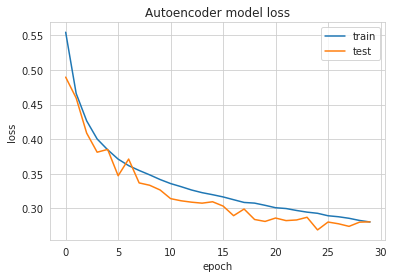

In [68]:
best_loss_value_ann_2h_unisoftsigbinlosadam = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam, './Figures/ann_2h_unisoftsigbinlosadam.png')

In [69]:
pred_ann_2h_prob_unisoftsigbinlosadam, pred_ann_2h_01_unisoftsigbinlosadam = ann_predict(ann_2h_unisoftsigbinlosadam,enc_test_x_asam)

Overall accuracy of Neural Network model: 0.8683854950511364
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     45805
           1       0.87      0.86      0.87     45226

   micro avg       0.87      0.87      0.87     91031
   macro avg       0.87      0.87      0.87     91031
weighted avg       0.87      0.87      0.87     91031



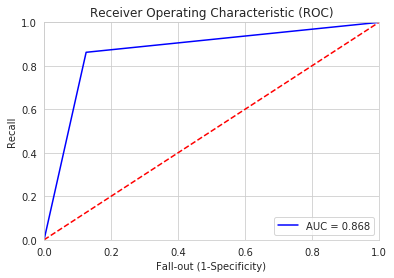

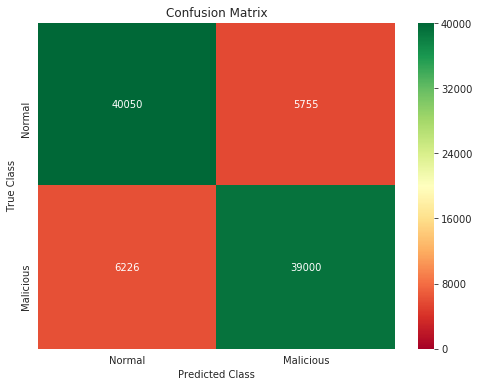

In [70]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam, pred_ann_2h_01_unisoftsigbinlosadam, './Figures/ROC_ann_2h_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam_redds10bal.png')

In [71]:
ann_2h_unisoftsigbinlosadam2 = ann_2h_(neurons=48,
                                      encoded_train_x=enc_train_x_asal,
#                                       init_mode='glorot_uniform',
                                       init_mode='VarianceScaling',
#                                       activation_input='softsign',
                                      activation_input='relu',
#                                       weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      lr=0.05)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_19 (Dense)             (None, 36)                1764      
_________________________________________________________________
dense_20 (Dense)             (None, 24)                888       
_________________________________________________________________
batch_normalization_5 (Batch (None, 24)                96        
_________________________________________________________________
dropout_5 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 25        
Total params: 4,357
Trainable params: 4,309
Non-trainable params: 48
_________________________________________________________________
None


In [72]:
hist_ann_2h_unisoftsigbinlosadam2 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam2_redds10bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam2,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 48)

Sat Jun  8 22:46:44 2019
Train on 233038 samples, validate on 58260 samples
Epoch 1/200
233038/233038 [==============================] - 19s 83us/step - loss: 0.5931 - acc: 0.6636 - val_loss: 0.5586 - val_acc: 0.6881
Epoch 2/200
233038/233038 [==============================] - 19s 80us/step - loss: 0.5427 - acc: 0.7032 - val_loss: 0.5276 - val_acc: 0.7082
Epoch 3/200
233038/233038 [==============================] - 19s 80us/step - loss: 0.5384 - acc: 0.7035 - val_loss: 0.5311 - val_acc: 0.7021
Epoch 4/200
233038/233038 [==============================] - 19s 80us/step - loss: 0.5186 - acc: 0.7204 - val_loss: 0.5056 - val_acc: 0.7207
Epoch 5/200
233038/233038 [==============================] - 19s 80us/step - loss: 0.5041 - acc: 0.7308 - val_loss: 0.4979 - val_acc: 0.7402
Epoch 6/200
233038/233038 [==============================] - 18s 79us/step - loss: 0.4923 - acc: 0.7413 - val_loss: 0.4802 - val_acc: 0.7490
Epoch 7/200
233038/233038 [==============================] - 19s 80us/step - l

Best loss value: 0.5124441242896121


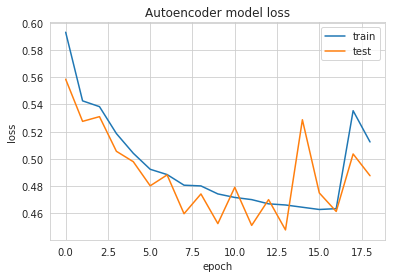

In [73]:
best_loss_value_ann_2h_unisoftsigbinlosadam2 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam2, './Figures/ann_2h_unisoftsigbinlosadam2.png')

In [74]:
pred_ann_2h_prob_unisoftsigbinlosadam2, pred_ann_2h_01_unisoftsigbinlosadam2 = ann_predict(ann_2h_unisoftsigbinlosadam2,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.7324647647504696
              precision    recall  f1-score   support

           0       0.83      0.59      0.69     45805
           1       0.68      0.88      0.77     45226

   micro avg       0.73      0.73      0.73     91031
   macro avg       0.75      0.73      0.73     91031
weighted avg       0.75      0.73      0.73     91031



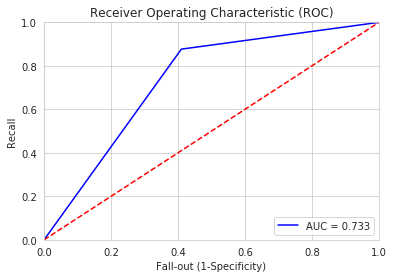

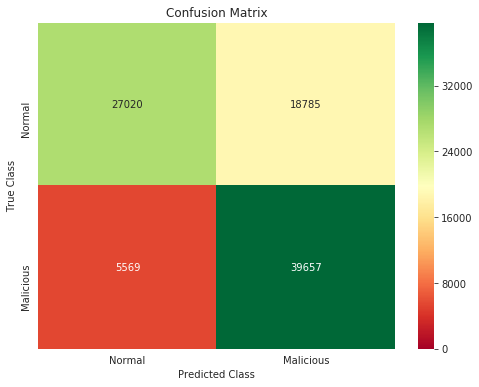

In [75]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam2, pred_ann_2h_01_unisoftsigbinlosadam2, './Figures/ROC_ann_2h_unisoftsigbinlosadam2_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam2_redds10bal.png')

In [76]:
ann_2h_unisoftsigbinlosadam3 = ann_2h(neurons=48,
                                      encoded_train_x=enc_train_x_asam,
                                      init_mode='uniform',
                                      activation_input='relu',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_23 (Dense)             (None, 36)                1764      
_________________________________________________________________
dense_24 (Dense)             (None, 24)                888       
_________________________________________________________________
batch_normalization_6 (Batch (None, 24)                96        
_________________________________________________________________
dropout_6 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 25        
Total params: 4,357
Trainable params: 4,309
Non-trainable params: 48
_________________________________________________________________
None


In [77]:
hist_ann_2h_unisoftsigbinlosadam3 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam3_redds10bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam3,
                                        enc_train_x = enc_train_x_asam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 48)

Sat Jun  8 22:52:34 2019
Train on 233038 samples, validate on 58260 samples
Epoch 1/200
233038/233038 [==============================] - 20s 87us/step - loss: 0.5230 - acc: 0.7136 - val_loss: 0.4541 - val_acc: 0.7677
Epoch 2/200
233038/233038 [==============================] - 19s 84us/step - loss: 0.4357 - acc: 0.7789 - val_loss: 0.3994 - val_acc: 0.8055
Epoch 3/200
233038/233038 [==============================] - 20s 84us/step - loss: 0.4039 - acc: 0.7978 - val_loss: 0.3811 - val_acc: 0.8129
Epoch 4/200
233038/233038 [==============================] - 19s 83us/step - loss: 0.3798 - acc: 0.8121 - val_loss: 0.4078 - val_acc: 0.7937
Epoch 5/200
233038/233038 [==============================] - 19s 83us/step - loss: 0.3643 - acc: 0.8195 - val_loss: 0.3422 - val_acc: 0.8294
Epoch 6/200
233038/233038 [==============================] - 19s 83us/step - loss: 0.3498 - acc: 0.8275 - val_loss: 0.3306 - val_acc: 0.8353
Epoch 7/200
233038/233038 [==============================] - 19s 82us/step - l

In [78]:
# hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.23804252855155847


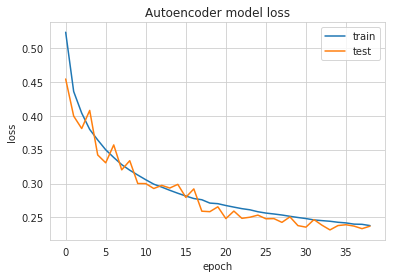

In [79]:
best_loss_value_ann_2h_unisoftsigbinlosadam3 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam3, './Figures/ann_2h_unisoftsigbinlosadam3.png')

In [80]:
pred_ann_2h_prob_unisoftsigbinlosadam3, pred_ann_2h_01_unisoftsigbinlosadam3 = ann_predict(ann_2h_unisoftsigbinlosadam3,enc_test_x_asam)

Overall accuracy of Neural Network model: 0.8909821928793488
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     45805
           1       0.87      0.92      0.89     45226

   micro avg       0.89      0.89      0.89     91031
   macro avg       0.89      0.89      0.89     91031
weighted avg       0.89      0.89      0.89     91031



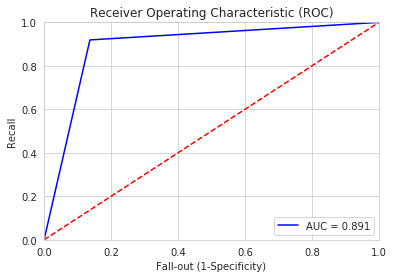

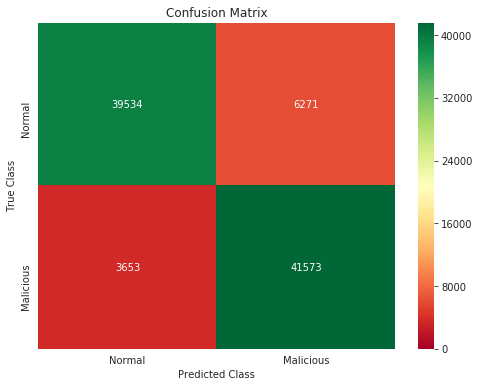

In [81]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam3, pred_ann_2h_01_unisoftsigbinlosadam3, './Figures/ROC_ann_2h_unisoftsigbinlosadam3_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam3_redds10bal.png')

#### >>>>>>>>>>>>>>>>>>>

In [82]:
ann_2h_unisoftsigbinlosadam4 = ann_2h(neurons=48,
                                      encoded_train_x=enc_train_x_asal,
                                      init_mode='uniform',
                                      activation_input='relu',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_27 (Dense)             (None, 36)                1764      
_________________________________________________________________
dense_28 (Dense)             (None, 24)                888       
_________________________________________________________________
batch_normalization_7 (Batch (None, 24)                96        
_________________________________________________________________
dropout_7 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 25        
Total params: 4,357
Trainable params: 4,309
Non-trainable params: 48
_________________________________________________________________
None


In [83]:
hist_ann_2h_unisoftsigbinlosadam4 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam4_redds10bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam4,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 48)

Sat Jun  8 23:04:28 2019
Train on 233038 samples, validate on 58260 samples
Epoch 1/200
233038/233038 [==============================] - 20s 87us/step - loss: 0.5431 - acc: 0.7039 - val_loss: 0.4910 - val_acc: 0.7500
Epoch 2/200
233038/233038 [==============================] - 19s 83us/step - loss: 0.4678 - acc: 0.7584 - val_loss: 0.4446 - val_acc: 0.7770
Epoch 3/200
233038/233038 [==============================] - 19s 83us/step - loss: 0.4375 - acc: 0.7795 - val_loss: 0.4220 - val_acc: 0.7924
Epoch 4/200
233038/233038 [==============================] - 19s 82us/step - loss: 0.4139 - acc: 0.7949 - val_loss: 0.3916 - val_acc: 0.8091
Epoch 5/200
233038/233038 [==============================] - 19s 81us/step - loss: 0.3964 - acc: 0.8053 - val_loss: 0.3785 - val_acc: 0.8223
Epoch 6/200
233038/233038 [==============================] - 19s 80us/step - loss: 0.3827 - acc: 0.8141 - val_loss: 0.3708 - val_acc: 0.8182
Epoch 7/200
233038/233038 [==============================] - 19s 80us/step - l

In [84]:
# hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.28699916715460055


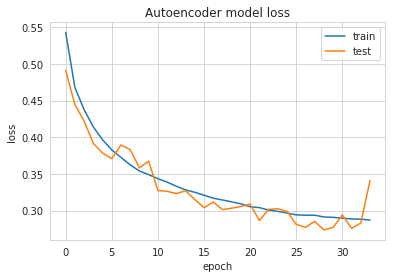

In [85]:
best_loss_value_ann_2h_unisoftsigbinlosadam4 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam4, './Figures/ann_2h_unisoftsigbinlosadam4.png')

In [86]:
pred_ann_2h_prob_unisoftsigbinlosadam4, pred_ann_2h_01_unisoftsigbinlosadam4 = ann_predict(ann_2h_unisoftsigbinlosadam4,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.8336171194428271
              precision    recall  f1-score   support

           0       0.81      0.88      0.84     45805
           1       0.86      0.79      0.82     45226

   micro avg       0.83      0.83      0.83     91031
   macro avg       0.84      0.83      0.83     91031
weighted avg       0.84      0.83      0.83     91031



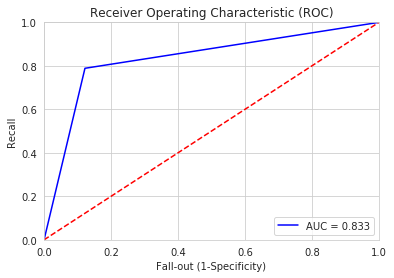

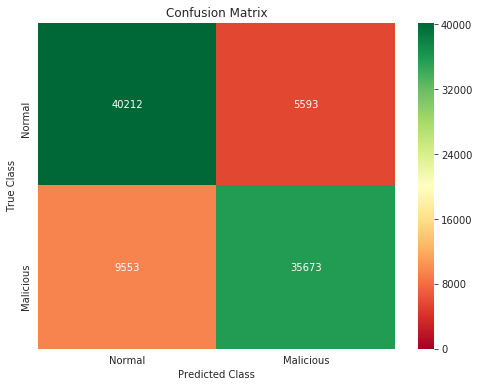

In [87]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam4, pred_ann_2h_01_unisoftsigbinlosadam4, './Figures/ROC_ann_2h_unisoftsigbinlosadam4_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam4_redds10bal.png')

ann_2h__(neurons,encoded_train_x,activation_input,
               dropout_rate,activation_output,
               loss,optimizer)

In [88]:
ann_2h_unisoftsigbinlosadam5 = ann_2h__(neurons=48,
                                      encoded_train_x=enc_train_x_asal,
                                      activation_input='relu',
#                                       dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_31 (Dense)             (None, 36)                1764      
_________________________________________________________________
dense_32 (Dense)             (None, 24)                888       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 25        
Total params: 4,261
Trainable params: 4,261
Non-trainable params: 0
_________________________________________________________________
None


In [89]:
hist_ann_2h_unisoftsigbinlosadam5 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam5_redds10bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam5,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 48)

Sat Jun  8 23:14:39 2019
Train on 233038 samples, validate on 58260 samples
Epoch 1/200
233038/233038 [==============================] - 16s 68us/step - loss: 0.5335 - acc: 0.7112 - val_loss: 0.4631 - val_acc: 0.7609
Epoch 2/200
233038/233038 [==============================] - 15s 65us/step - loss: 0.4405 - acc: 0.7769 - val_loss: 0.4186 - val_acc: 0.7944
Epoch 3/200
233038/233038 [==============================] - 15s 64us/step - loss: 0.4023 - acc: 0.7991 - val_loss: 0.3796 - val_acc: 0.8180
Epoch 4/200
233038/233038 [==============================] - 15s 63us/step - loss: 0.3777 - acc: 0.8136 - val_loss: 0.3726 - val_acc: 0.8162
Epoch 5/200
233038/233038 [==============================] - 15s 64us/step - loss: 0.3597 - acc: 0.8246 - val_loss: 0.3576 - val_acc: 0.8254
Epoch 6/200
233038/233038 [==============================] - 15s 64us/step - loss: 0.3445 - acc: 0.8333 - val_loss: 0.3339 - val_acc: 0.8346
Epoch 7/200
233038/233038 [==============================] - 15s 63us/step - l

In [90]:
# hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.19174531424408708


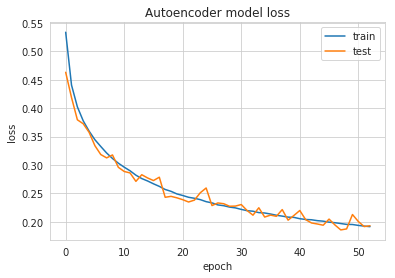

In [91]:
best_loss_value_ann_2h_unisoftsigbinlosadam5 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam5, './Figures/ann_2h_unisoftsigbinlosadam5.png')

In [92]:
pred_ann_2h_prob_unisoftsigbinlosadam5, pred_ann_2h_01_unisoftsigbinlosadam5 = ann_predict(ann_2h_unisoftsigbinlosadam5,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.9109863672814755
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     45805
           1       0.90      0.92      0.91     45226

   micro avg       0.91      0.91      0.91     91031
   macro avg       0.91      0.91      0.91     91031
weighted avg       0.91      0.91      0.91     91031



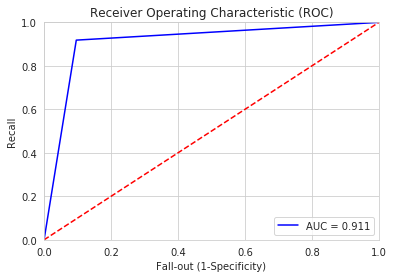

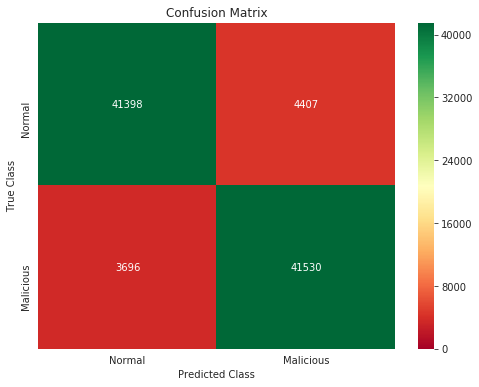

In [93]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam5, pred_ann_2h_01_unisoftsigbinlosadam5, './Figures/ROC_ann_2h_unisoftsigbinlosadam5_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam5_redds10bal.png')

In [94]:
ann_2h_unisoftsigbinlosadam6 = ann_2h__(neurons=48,
                                      encoded_train_x=enc_train_x_asam,
                                      activation_input='relu',
#                                       dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_35 (Dense)             (None, 36)                1764      
_________________________________________________________________
dense_36 (Dense)             (None, 24)                888       
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 25        
Total params: 4,261
Trainable params: 4,261
Non-trainable params: 0
_________________________________________________________________
None


In [95]:
hist_ann_2h_unisoftsigbinlosadam6 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam6_redds10bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam6,
                                        enc_train_x = enc_train_x_asam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 48)

Sat Jun  8 23:26:49 2019
Train on 233038 samples, validate on 58260 samples
Epoch 1/200
233038/233038 [==============================] - 16s 69us/step - loss: 0.5255 - acc: 0.7154 - val_loss: 0.4635 - val_acc: 0.7600
Epoch 2/200
233038/233038 [==============================] - 15s 65us/step - loss: 0.4348 - acc: 0.7819 - val_loss: 0.4168 - val_acc: 0.7860
Epoch 3/200
233038/233038 [==============================] - 15s 65us/step - loss: 0.3919 - acc: 0.8080 - val_loss: 0.3728 - val_acc: 0.8181
Epoch 4/200
233038/233038 [==============================] - 15s 65us/step - loss: 0.3647 - acc: 0.8224 - val_loss: 0.3442 - val_acc: 0.8424
Epoch 5/200
233038/233038 [==============================] - 15s 65us/step - loss: 0.3426 - acc: 0.8351 - val_loss: 0.3258 - val_acc: 0.8448
Epoch 6/200
233038/233038 [==============================] - 15s 63us/step - loss: 0.3265 - acc: 0.8435 - val_loss: 0.3213 - val_acc: 0.8404
Epoch 7/200
233038/233038 [==============================] - 15s 63us/step - l

In [96]:
# hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.20579479199808376


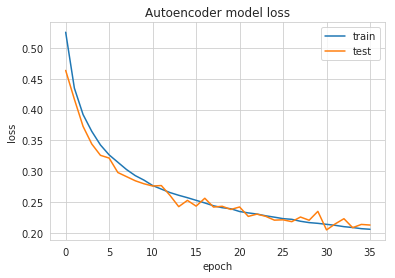

In [97]:
best_loss_value_ann_2h_unisoftsigbinlosadam6 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam6, './Figures/ann_2h_unisoftsigbinlosadam6.png')

In [98]:
pred_ann_2h_prob_unisoftsigbinlosadam6, pred_ann_2h_01_unisoftsigbinlosadam6 = ann_predict(ann_2h_unisoftsigbinlosadam6,enc_test_x_asam)

Overall accuracy of Neural Network model: 0.8929595412551768
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     45805
           1       0.90      0.88      0.89     45226

   micro avg       0.89      0.89      0.89     91031
   macro avg       0.89      0.89      0.89     91031
weighted avg       0.89      0.89      0.89     91031



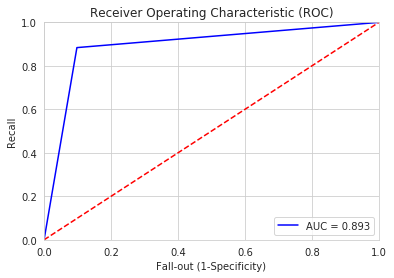

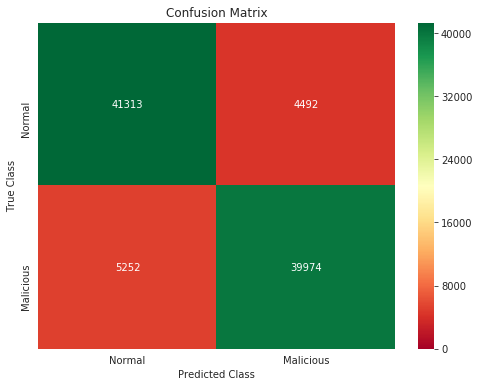

In [99]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam6, pred_ann_2h_01_unisoftsigbinlosadam6, './Figures/ROC_ann_2h_unisoftsigbinlosadam6_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam6_redds10bal.png')

In [100]:
enc_train_x_assal.shape

(291298, 32)

In [101]:
ann_2h_unisoftsigbinlosadam7 = ann_2h__(neurons=48,
                                      encoded_train_x=enc_train_x_asal,
                                      activation_input='tanh',
#                                       dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_39 (Dense)             (None, 36)                1764      
_________________________________________________________________
dense_40 (Dense)             (None, 24)                888       
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 25        
Total params: 4,261
Trainable params: 4,261
Non-trainable params: 0
_________________________________________________________________
None


In [102]:
hist_ann_2h_unisoftsigbinlosadam7 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam7_redds10bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam7,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 48)

Sat Jun  8 23:35:23 2019
Train on 233038 samples, validate on 58260 samples
Epoch 1/200
233038/233038 [==============================] - 16s 70us/step - loss: 0.5376 - acc: 0.7112 - val_loss: 0.4749 - val_acc: 0.7543
Epoch 2/200
233038/233038 [==============================] - 15s 66us/step - loss: 0.4406 - acc: 0.7791 - val_loss: 0.4256 - val_acc: 0.7796
Epoch 3/200
233038/233038 [==============================] - 15s 65us/step - loss: 0.4085 - acc: 0.7981 - val_loss: 0.3877 - val_acc: 0.8128
Epoch 4/200
233038/233038 [==============================] - 15s 65us/step - loss: 0.3853 - acc: 0.8120 - val_loss: 0.3888 - val_acc: 0.8064
Epoch 5/200
233038/233038 [==============================] - 15s 65us/step - loss: 0.3676 - acc: 0.8226 - val_loss: 0.3596 - val_acc: 0.8277
Epoch 6/200
233038/233038 [==============================] - 15s 65us/step - loss: 0.3521 - acc: 0.8305 - val_loss: 0.3591 - val_acc: 0.8266
Epoch 7/200
233038/233038 [==============================] - 15s 64us/step - l

In [103]:
# hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.22383322993855287


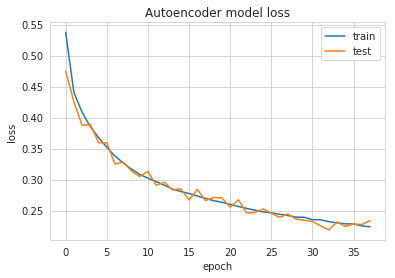

In [104]:
best_loss_value_ann_2h_unisoftsigbinlosadam7 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam7, './Figures/ann_2h_unisoftsigbinlosadam7.png')

In [105]:
pred_ann_2h_prob_unisoftsigbinlosadam7, pred_ann_2h_01_unisoftsigbinlosadam7 = ann_predict(ann_2h_unisoftsigbinlosadam7,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.895508123606244
              precision    recall  f1-score   support

           0       0.92      0.87      0.89     45805
           1       0.87      0.92      0.90     45226

   micro avg       0.90      0.90      0.90     91031
   macro avg       0.90      0.90      0.90     91031
weighted avg       0.90      0.90      0.90     91031



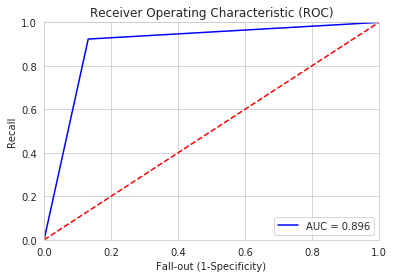

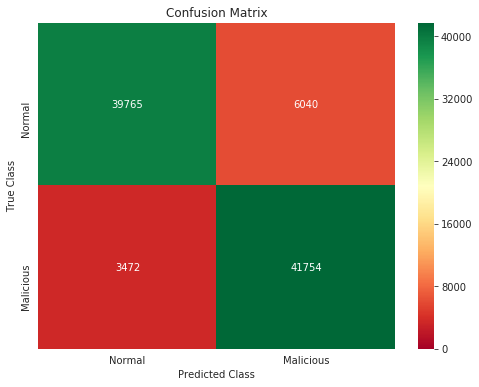

In [106]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam7, pred_ann_2h_01_unisoftsigbinlosadam7, './Figures/ROC_ann_2h_unisoftsigbinlosadam7_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam7_redds10bal.png')

In [107]:
from keras.utils import to_categorical
train_y_ = to_categorical(train_y)

In [108]:
ann_2h_unisoftsigbinlosadam8 = ann_2h__(neurons=48,
                                      encoded_train_x=enc_train_x_asal,
                                      activation_input='tanh',
#                                       dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='mean_squared_error',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_43 (Dense)             (None, 36)                1764      
_________________________________________________________________
dense_44 (Dense)             (None, 24)                888       
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 25        
Total params: 4,261
Trainable params: 4,261
Non-trainable params: 0
_________________________________________________________________
None


In [109]:
hist_ann_2h_unisoftsigbinlosadam8 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam8_redds10bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam8,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 48)

Sat Jun  8 23:44:26 2019
Train on 233038 samples, validate on 58260 samples
Epoch 1/200
233038/233038 [==============================] - 15s 64us/step - loss: 0.1850 - acc: 0.7120 - val_loss: 0.1574 - val_acc: 0.7703
Epoch 2/200
233038/233038 [==============================] - 14s 60us/step - loss: 0.1521 - acc: 0.7755 - val_loss: 0.1428 - val_acc: 0.7920
Epoch 3/200
233038/233038 [==============================] - 14s 60us/step - loss: 0.1377 - acc: 0.7992 - val_loss: 0.1315 - val_acc: 0.8065
Epoch 4/200
233038/233038 [==============================] - 14s 59us/step - loss: 0.1296 - acc: 0.8127 - val_loss: 0.1347 - val_acc: 0.8025
Epoch 5/200
233038/233038 [==============================] - 14s 59us/step - loss: 0.1235 - acc: 0.8222 - val_loss: 0.1194 - val_acc: 0.8285
Epoch 6/200
233038/233038 [==============================] - 14s 59us/step - loss: 0.1186 - acc: 0.8299 - val_loss: 0.1181 - val_acc: 0.8315
Epoch 7/200
233038/233038 [==============================] - 14s 59us/step - l

In [110]:
# hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.06677102882162225


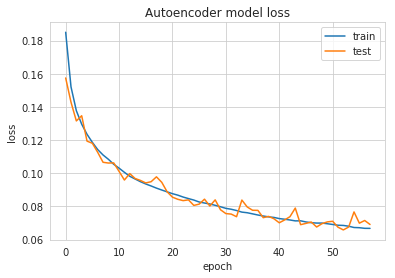

In [111]:
best_loss_value_ann_2h_unisoftsigbinlosadam8 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam8, './Figures/ann_2h_unisoftsigbinlosadam8.png')

In [112]:
pred_ann_2h_prob_unisoftsigbinlosadam8, pred_ann_2h_01_unisoftsigbinlosadam8 = ann_predict(ann_2h_unisoftsigbinlosadam8,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.9061858048357153
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     45805
           1       0.91      0.90      0.91     45226

   micro avg       0.91      0.91      0.91     91031
   macro avg       0.91      0.91      0.91     91031
weighted avg       0.91      0.91      0.91     91031



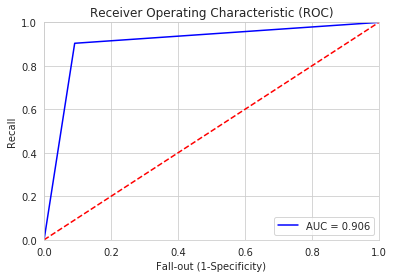

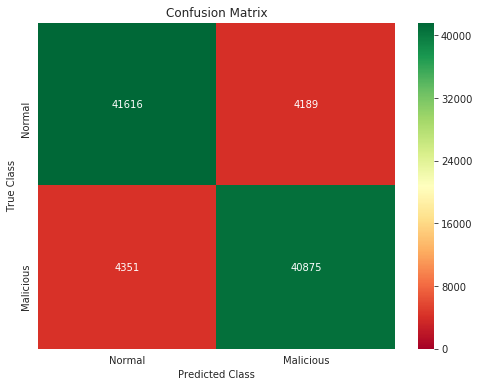

In [113]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam8, pred_ann_2h_01_unisoftsigbinlosadam8, './Figures/ROC_ann_2h_unisoftsigbinlosadam8_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam8_redds10bal.png')

In [114]:
ann_24n_unisoftsigbinlosadam = ann_1h_24n(neurons=48,
                                      encoded_train_x=train_x,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 48)                2352      
_________________________________________________________________
dense_47 (Dense)             (None, 24)                1176      
_________________________________________________________________
batch_normalization_8 (Batch (None, 24)                96        
_________________________________________________________________
dropout_8 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 25        
Total params: 3,649
Trainable params: 3,601
Non-trainable params: 48
_________________________________________________________________
None


In [115]:
hist_ann_24n_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann_24n_unisoftsigbinlosadam_redds10bal.h5",
                                        ann = ann_24n_unisoftsigbinlosadam,
                                        enc_train_x = train_x,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 48)

Sat Jun  8 23:56:33 2019
Train on 233038 samples, validate on 58260 samples
Epoch 1/200
233038/233038 [==============================] - 20s 87us/step - loss: 0.5173 - acc: 0.7180 - val_loss: 0.4603 - val_acc: 0.7643
Epoch 2/200
233038/233038 [==============================] - 19s 82us/step - loss: 0.4409 - acc: 0.7755 - val_loss: 0.4493 - val_acc: 0.7659
Epoch 3/200
233038/233038 [==============================] - 19s 82us/step - loss: 0.4097 - acc: 0.7941 - val_loss: 0.3985 - val_acc: 0.7997
Epoch 4/200
233038/233038 [==============================] - 19s 81us/step - loss: 0.3910 - acc: 0.8058 - val_loss: 0.3796 - val_acc: 0.8155
Epoch 5/200
233038/233038 [==============================] - 19s 82us/step - loss: 0.3759 - acc: 0.8149 - val_loss: 0.3486 - val_acc: 0.8272
Epoch 6/200
233038/233038 [==============================] - 19s 81us/step - loss: 0.3622 - acc: 0.8219 - val_loss: 0.3509 - val_acc: 0.8257
Epoch 7/200
233038/233038 [==============================] - 19s 81us/step - l

Best loss value: 0.26720297092955336


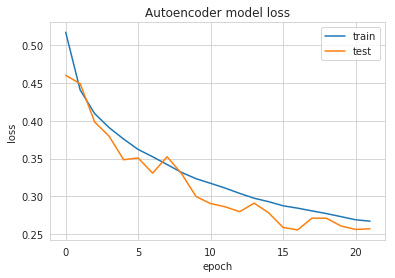

In [116]:
best_loss_value_ann_24n_unisoftsigbinlosadam = plot_hist_auto(hist_ann_24n_unisoftsigbinlosadam, './Figures/ann_24_unisoftsigbinlosadam.png')

In [117]:
pred_ann_24n_prob_unisoftsigbinlosadam, pred_ann_24n_01_unisoftsigbinlosadam = ann_predict(ann_24n_unisoftsigbinlosadam,test_x)

Overall accuracy of Neural Network model: 0.8739879821159825
              precision    recall  f1-score   support

           0       0.89      0.86      0.87     45805
           1       0.86      0.89      0.88     45226

   micro avg       0.87      0.87      0.87     91031
   macro avg       0.87      0.87      0.87     91031
weighted avg       0.87      0.87      0.87     91031



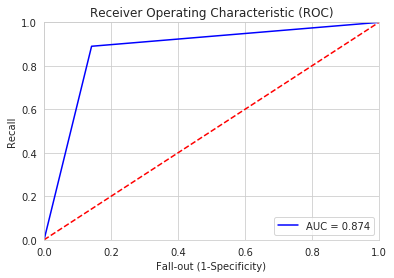

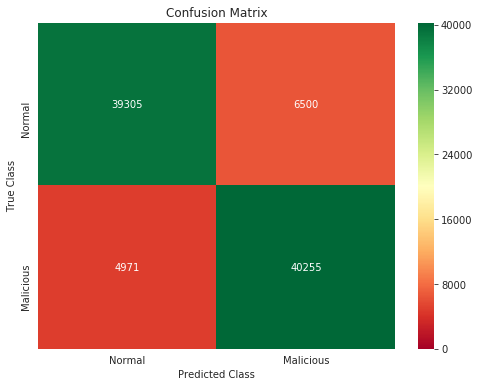

In [118]:
plot_roc_cm(pred_ann_24n_01_unisoftsigbinlosadam, pred_ann_24n_01_unisoftsigbinlosadam, './Figures/ROC_ann_24n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann_24n_unisoftsigbinlosadam_redds10bal.png')

In [119]:
from sklearn.ensemble import RandomForestClassifier

In [120]:
clf = RandomForestClassifier(n_estimators=300, 
                             criterion='gini', 
                             max_depth=16, 
#                              min_samples_split=2, 
                             #min_samples_leaf=1, 
                             max_features=0.3, 
                             #bootstrap=True,
                             oob_score=True,
                             random_state=23)  

In [121]:
start_time = time.time()
print(time.ctime(start_time))

clf.fit(enc_train_x_aslal, train_y)

pred_y_RF = cross_val_predict(estimator=clf,
                              X=np.array(enc_test_x_aslal),
                              y=test_y,
                              cv=KFold(n_splits=10, random_state=23),
                              n_jobs=2)

elapsed_time = (time.time() - start_time)
print("--- %s seconds ---" %elapsed_time)

print(sm.classification_report(test_y, pred_y_RF,digits=4))

Sun Jun  9 00:03:22 2019
--- 1466.085642337799 seconds ---
              precision    recall  f1-score   support

           0     0.9987    0.9819    0.9903     45805
           1     0.9820    0.9987    0.9903     45226

   micro avg     0.9903    0.9903    0.9903     91031
   macro avg     0.9904    0.9903    0.9903     91031
weighted avg     0.9904    0.9903    0.9903     91031



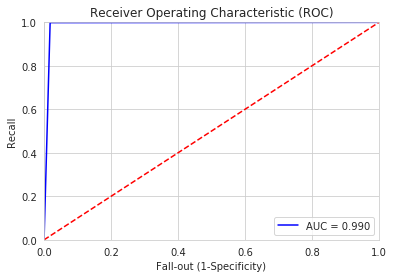

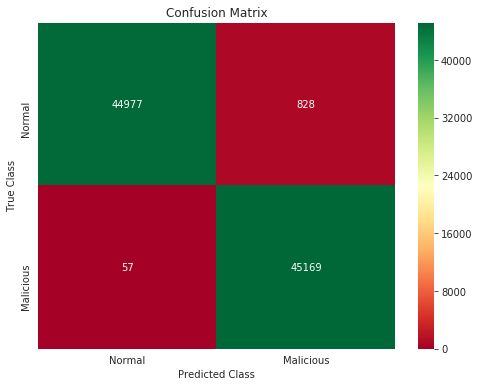

In [122]:
plot_roc_cm(pred_y_RF, pred_y_RF, './Figures/ROC_rf_E100MaxfautoMaxdnoneBootT_redds10bal.png', './Figures/CM_rf_E100MaxfautoMaxdnoneBootT_redds10bal.png')